# Mall Customers

**Obiettivo (ML non supervisionato)**: Usare tecniche di clustering (K-Means e DBSCAN) per individuare gruppi di clienti con comportamenti simili.

**Compiti specifici**:
- Applicare il clustering sui campi **Annual Income** e **Spending Score** e interpretare i gruppi trovati
- Visualizzare i cluster in un grafico 2D con colori diversi per ogni gruppo  
- Identificare il cluster che rappresenta i clienti ad **alto potenziale** (alto reddito e alto punteggio di spesa)
- Calcolare la **distanza media** dei punti dal centroide del proprio cluster per valutare la compattezza dei gruppi

## Importazione delle librerie necessarie

In [70]:
# Librerie base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Metriche di valutazione
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances

# Impostazioni grafiche
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## Preparare i dati

In [71]:
# Caricamento del dataset
df = pd.read_csv('Mall_Customers.csv')

print("Dimensioni del dataset:", df.shape)
print("\nPrime 5 righe:")
df.head()

Dimensioni del dataset: (200, 5)

Prime 5 righe:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [72]:
# Informazioni sul dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [73]:
# Preparazione dei dati per il clustering
# Focus su Annual Income e Spending Score

# Selezioniamo SOLO le feature richieste per il clustering
customer_features = df[['CustomerID', 'Annual Income (k$)', 'Spending Score (1-100)']].copy()
customer_features.columns = ['customer_id', 'annual_income', 'spending_score']
print("- Annual Income (k$): reddito annuale")  
print("- Spending Score (1-100): punteggio di spesa")
print(f"\nDimensioni dataset: {customer_features.shape}")
print("\nPrime 5 righe:")
customer_features.head()

- Annual Income (k$): reddito annuale
- Spending Score (1-100): punteggio di spesa

Dimensioni dataset: (200, 3)

Prime 5 righe:


,customer_id,annual_income,spending_score
0,1,15,39
1,2,15,81
2,3,16,6
3,4,16,77
4,5,17,40


Questi dati sono perfetti per identificare segmenti di clienti basati su **capacità di spesa** (Annual Income) e **comportamento di acquisto** (Spending Score).

## PARTE 3 — Pipeline Unsupervised

1. **Raccolta dati** 
2. **Pulizia dati**: rimuovere NaN, gestire outlier
3. **Feature engineering**: creare colonne utili
4. **Standardizzazione**: rescale dei dati (importantissimo!)
5. **Modello**: applichiamo k-Means, DBSCAN o altri
6. **Valutazione qualitativa** (silhouette, visualizzazione 2D)
7. **Interpretazione dei gruppi**

### 2. Pulizia dati e analisi esplorativa

In [74]:
# Controllo valori mancanti
print("Valori mancanti:")
print(customer_features.isnull().sum())

# Controllo duplicati
print(f"\nDuplicati: {customer_features.duplicated().sum()}")

# Rimozione eventuali valori mancanti
customer_features_clean = customer_features.dropna()
print(f"\nDimensioni dopo pulizia: {customer_features_clean.shape}")

Valori mancanti:
customer_id       0
annual_income     0
spending_score    0
dtype: int64

Duplicati: 0

Dimensioni dopo pulizia: (200, 3)


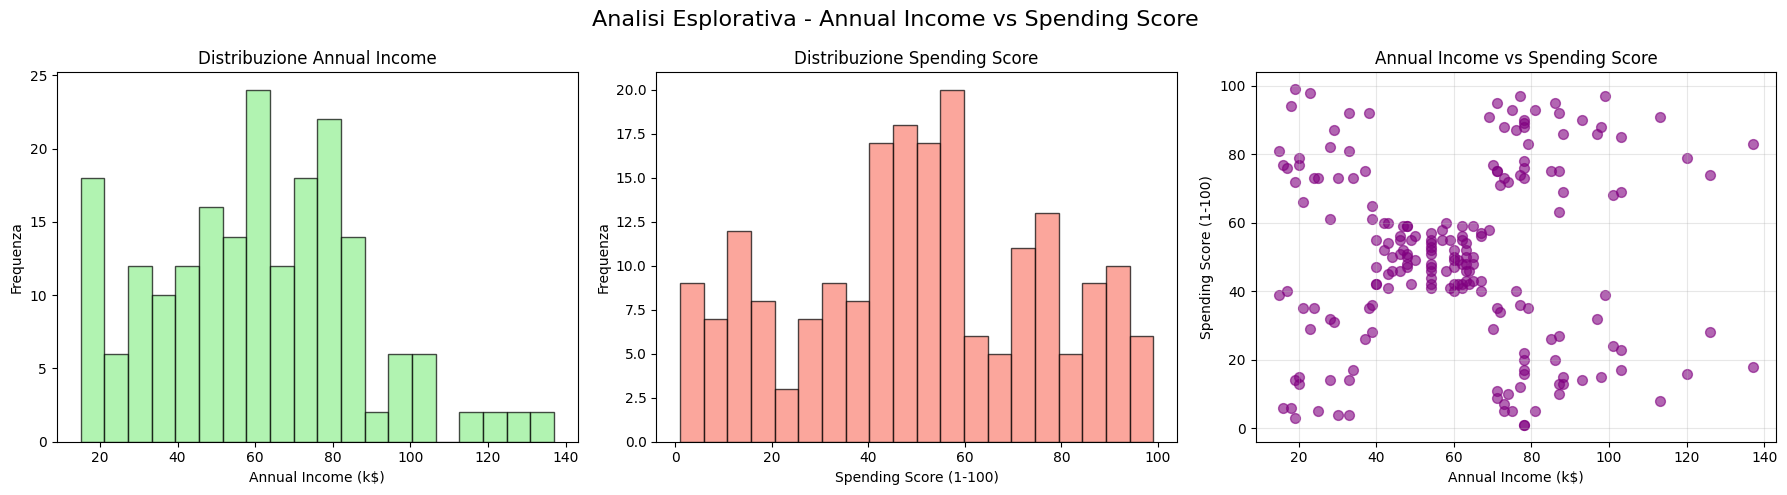

In [75]:
# Visualizzazione distribuzione delle variabili (Annual Income e Spending Score)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Analisi Esplorativa - Annual Income vs Spending Score', fontsize=16)

# Annual Income
axes[0].hist(customer_features_clean['annual_income'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0].set_title('Distribuzione Annual Income')
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Frequenza')

# Spending Score
axes[1].hist(customer_features_clean['spending_score'], bins=20, alpha=0.7, color='salmon', edgecolor='black')
axes[1].set_title('Distribuzione Spending Score')
axes[1].set_xlabel('Spending Score (1-100)')
axes[1].set_ylabel('Frequenza')

# Scatter plot delle due variabili
axes[2].scatter(customer_features_clean['annual_income'], customer_features_clean['spending_score'], 
               alpha=0.6, color='purple', s=50)
axes[2].set_title('Annual Income vs Spending Score')
axes[2].set_xlabel('Annual Income (k$)')
axes[2].set_ylabel('Spending Score (1-100)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

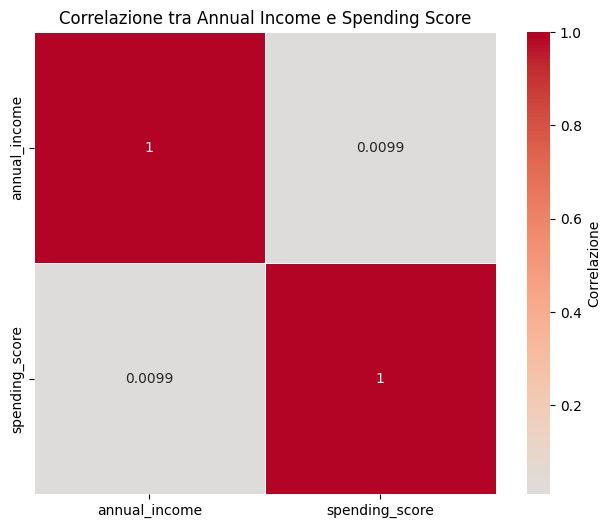

Correlazione tra Annual Income e Spending Score: 0.010


In [76]:
# Matrice di correlazione tra Annual Income e Spending Score
plt.figure(figsize=(8, 6))
correlation_matrix = customer_features_clean[['annual_income', 'spending_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlazione'})
plt.title('Correlazione tra Annual Income e Spending Score')
plt.show()

print(f"Correlazione tra Annual Income e Spending Score: {correlation_matrix.iloc[0,1]:.3f}")

### 3. Feature Engineering

In [77]:
# Ci concentriamo solo su Annual Income e Spending Score

customer_features_engineered = customer_features_clean.copy()
print(f"Numero di clienti: {len(customer_features_engineered)}")
customer_features_engineered.head()

Numero di clienti: 200


,customer_id,annual_income,spending_score
0,1,15,39
1,2,15,81
2,3,16,6
3,4,16,77
4,5,17,40


### 4. Distanza

In [78]:
# Standardizzazione dei dati 
features_for_clustering = ['annual_income', 'spending_score']
X = customer_features_engineered[features_for_clustering]

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("=== STANDARDIZZAZIONE DATI ===")
print("Dati prima della standardizzazione:")
print(X.describe())
print("\nDati dopo la standardizzazione:")
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
print(X_scaled_df.describe())

=== STANDARDIZZAZIONE DATI ===
Dati prima della standardizzazione:
       annual_income  spending_score
count     200.000000      200.000000
mean       60.560000       50.200000
std        26.264721       25.823522
min        15.000000        1.000000
25%        41.500000       34.750000
50%        61.500000       50.000000
75%        78.000000       73.000000
max       137.000000       99.000000

Dati dopo la standardizzazione:
       annual_income  spending_score
count   2.000000e+02    2.000000e+02
mean   -2.131628e-16   -1.465494e-16
std     1.002509e+00    1.002509e+00
min    -1.738999e+00   -1.910021e+00
25%    -7.275093e-01   -5.997931e-01
50%     3.587926e-02   -7.764312e-03
75%     6.656748e-01    8.851316e-01
max     2.917671e+00    1.894492e+00


In [79]:
# Esempio di calcolo distanza tra clienti
# Distanza tra i primi due clienti
dist = euclidean_distances([X_scaled[0]], [X_scaled[1]])
print(f"Distanza euclidea tra cliente 0 e 1: {dist[0][0]:.4f}")

# Distanza tra i primi tre clienti
dist_matrix = euclidean_distances(X_scaled[:3])
print("\nMatrice delle distanze tra i primi 3 clienti:")
print(pd.DataFrame(dist_matrix, 
                   index=[f'Cliente {i}' for i in range(3)],
                   columns=[f'Cliente {i}' for i in range(3)]))

Distanza euclidea tra cliente 0 e 1: 1.6305

Matrice delle distanze tra i primi 3 clienti:
           Cliente 0  Cliente 1  Cliente 2
Cliente 0   0.000000   1.630506   1.281680
Cliente 1   1.630506   0.000000   2.911867
Cliente 2   1.281680   2.911867   0.000000


### 5. Applicazione degli algoritmi di clustering

#### 5.1 K-Means Clustering

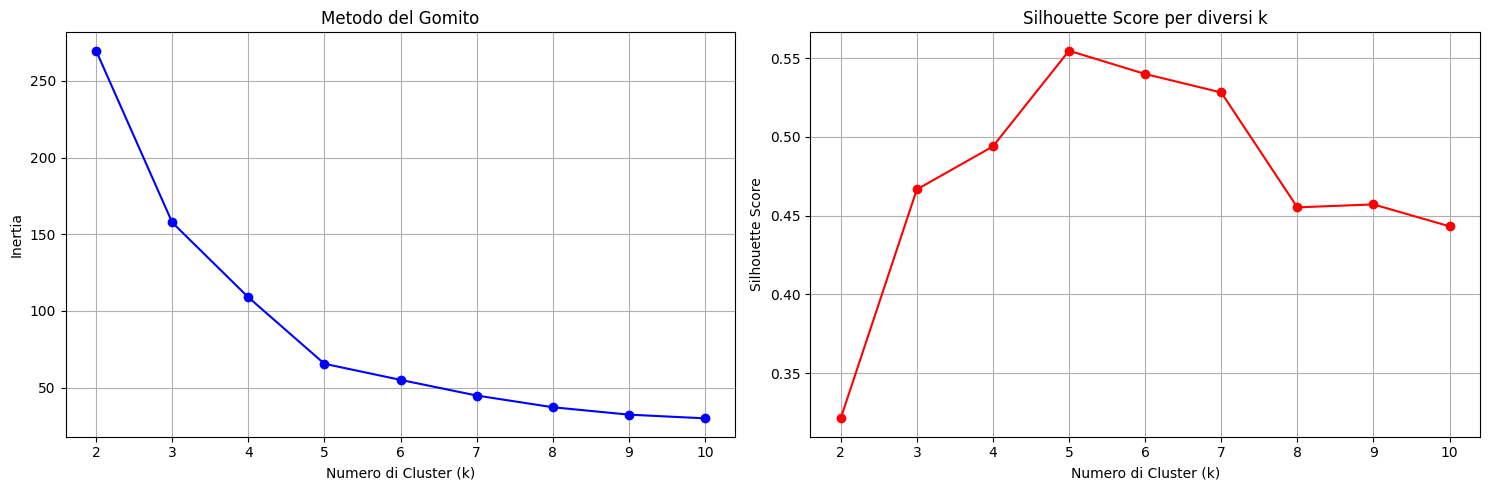

Miglior numero di cluster basato su silhouette score: 5
Silhouette score corrispondente: 0.5547


In [80]:
# Metodo del gomito per trovare il numero ottimale di cluster
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizzazione metodo del gomito
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow method
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Numero di Cluster (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Metodo del Gomito')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Numero di Cluster (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score per diversi k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Miglior k basato su silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Miglior numero di cluster basato su silhouette score: {best_k}")
print(f"Silhouette score corrispondente: {max(silhouette_scores):.4f}")

In [81]:
# Applicazione K-Means con il numero ottimale di cluster
kmeans_optimal = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_scaled)

# Aggiunta delle etichette al dataframe
customer_features_engineered['kmeans_cluster'] = kmeans_labels

print(f" K-Means applicato con {best_k} cluster")
print("Distribuzione dei cluster:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print(cluster_counts)

# Ottenimento dei centroidi
centroids = kmeans_optimal.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)

print(f"\n=== CENTROIDI DEI CLUSTER (valori originali) ===")
centroids_df = pd.DataFrame(centroids_original, columns=['Annual_Income', 'Spending_Score'])
centroids_df.index.name = 'Cluster'
print(centroids_df.round(1))

 K-Means applicato con 5 cluster
Distribuzione dei cluster:
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64

=== CENTROIDI DEI CLUSTER (valori originali) ===
         Annual_Income  Spending_Score
Cluster                               
0                 55.3            49.5
1                 86.5            82.1
2                 25.7            79.4
3                 88.2            17.1
4                 26.3            20.9


#### 5.2 Calcolo Distanze dai Centroidi e Compattezza dei Cluster

In [82]:
# Calcolo della distanza media dei punti dal centroide del proprio cluster
print("=== CALCOLO DISTANZE DAI CENTROIDI ===")

# Calcolo distanze per ogni cluster
cluster_distances = {}
cluster_compactness = {}

for cluster_id in range(best_k):
    # Seleziona i punti del cluster
    cluster_mask = kmeans_labels == cluster_id
    cluster_points = X_scaled[cluster_mask]
    
    if len(cluster_points) > 0:
        # Calcola le distanze dal centroide
        centroid = centroids[cluster_id]
        distances = np.sqrt(np.sum((cluster_points - centroid)**2, axis=1))
        
        cluster_distances[cluster_id] = distances
        cluster_compactness[cluster_id] = {
            'mean_distance': np.mean(distances),
            'std_distance': np.std(distances),
            'max_distance': np.max(distances),
            'min_distance': np.min(distances),
            'num_points': len(distances)
        }
        
        print(f"Cluster {cluster_id}:")
        print(f"  - Numero punti: {len(distances)}")
        print(f"  - Distanza media dal centroide: {np.mean(distances):.3f}")
        print(f"  - Deviazione standard: {np.std(distances):.3f}")
        print(f"  - Compattezza (1/dist_media): {1/np.mean(distances):.3f}")
        print()

# Cluster più compatto (distanza media minore)
most_compact_cluster = min(cluster_compactness.keys(), 
                          key=lambda x: cluster_compactness[x]['mean_distance'])
print(f"Cluster più compatto: {most_compact_cluster} (distanza media: {cluster_compactness[most_compact_cluster]['mean_distance']:.3f})")

=== CALCOLO DISTANZE DAI CENTROIDI ===
Cluster 0:
  - Numero punti: 81
  - Distanza media dal centroide: 0.387
  - Deviazione standard: 0.174
  - Compattezza (1/dist_media): 2.587

Cluster 1:
  - Numero punti: 39
  - Distanza media dal centroide: 0.627
  - Deviazione standard: 0.336
  - Compattezza (1/dist_media): 1.594

Cluster 2:
  - Numero punti: 22
  - Distanza media dal centroide: 0.447
  - Deviazione standard: 0.196
  - Compattezza (1/dist_media): 2.236

Cluster 3:
  - Numero punti: 35
  - Distanza media dal centroide: 0.625
  - Deviazione standard: 0.368
  - Compattezza (1/dist_media): 1.601

Cluster 4:
  - Numero punti: 23
  - Distanza media dal centroide: 0.549
  - Deviazione standard: 0.172
  - Compattezza (1/dist_media): 1.821

Cluster più compatto: 0 (distanza media: 0.387)


#### 5.3 Identificazione Clienti ad Alto Potenziale

In [83]:
# Identificazione del cluster ad alto potenziale
# Cerchiamo il cluster con ALTO reddito E ALTO spending score

print("=== IDENTIFICAZIONE CLIENTI AD ALTO POTENZIALE ===")
print("Criteri: Alto Annual Income E Alto Spending Score\n")

# Analisi dei centroidi per trovare il cluster ad alto potenziale
high_potential_cluster = None
max_combined_score = 0

for cluster_id in range(best_k):
    income = centroids_original[cluster_id][0]  # Annual Income
    spending = centroids_original[cluster_id][1]  # Spending Score
    
    # Score combinato (normalizzato)
    # Income su scala 0-137, Spending su scala 0-100
    income_norm = income / 137  # Normalizza reddito
    spending_norm = spending / 100  # Normalizza spending score
    combined_score = (income_norm + spending_norm) / 2
    
    print(f"Cluster {cluster_id}:")
    print(f"  - Annual Income medio: {income:.1f}k$")
    print(f"  - Spending Score medio: {spending:.1f}")
    print(f"  - Score combinato: {combined_score:.3f}")
    print(f"  - Numero clienti: {cluster_compactness[cluster_id]['num_points']}")
    
    if combined_score > max_combined_score:
        max_combined_score = combined_score
        high_potential_cluster = cluster_id
    print()

print(f"CLUSTER AD ALTO POTENZIALE: {high_potential_cluster}")
print(f"   Score combinato: {max_combined_score:.3f}")
print(f"   Annual Income: {centroids_original[high_potential_cluster][0]:.1f}k$")
print(f"   Spending Score: {centroids_original[high_potential_cluster][1]:.1f}")
print(f"   Numero clienti: {cluster_compactness[high_potential_cluster]['num_points']}")

# Salva l'informazione del cluster ad alto potenziale
customer_features_engineered['is_high_potential'] = (customer_features_engineered['kmeans_cluster'] == high_potential_cluster)
high_potential_customers = customer_features_engineered[customer_features_engineered['is_high_potential']]

print(f"\n STATISTICHE CLIENTI AD ALTO POTENZIALE:")
print(f"   - Reddito medio: {high_potential_customers['annual_income'].mean():.1f}k$ (±{high_potential_customers['annual_income'].std():.1f})")
print(f"   - Spending Score medio: {high_potential_customers['spending_score'].mean():.1f} (±{high_potential_customers['spending_score'].std():.1f})")

=== IDENTIFICAZIONE CLIENTI AD ALTO POTENZIALE ===
Criteri: Alto Annual Income E Alto Spending Score

Cluster 0:
  - Annual Income medio: 55.3k$
  - Spending Score medio: 49.5
  - Score combinato: 0.449
  - Numero clienti: 81

Cluster 1:
  - Annual Income medio: 86.5k$
  - Spending Score medio: 82.1
  - Score combinato: 0.726
  - Numero clienti: 39

Cluster 2:
  - Annual Income medio: 25.7k$
  - Spending Score medio: 79.4
  - Score combinato: 0.491
  - Numero clienti: 22

Cluster 3:
  - Annual Income medio: 88.2k$
  - Spending Score medio: 17.1
  - Score combinato: 0.407
  - Numero clienti: 35

Cluster 4:
  - Annual Income medio: 26.3k$
  - Spending Score medio: 20.9
  - Score combinato: 0.201
  - Numero clienti: 23

CLUSTER AD ALTO POTENZIALE: 1
   Score combinato: 0.726
   Annual Income: 86.5k$
   Spending Score: 82.1
   Numero clienti: 39

 STATISTICHE CLIENTI AD ALTO POTENZIALE:
   - Reddito medio: 86.5k$ (±16.3)
   - Spending Score medio: 82.1 (±9.4)


### 6. Visualizzazione Cluster in 2D

<Figure size 1500x1000 with 0 Axes>

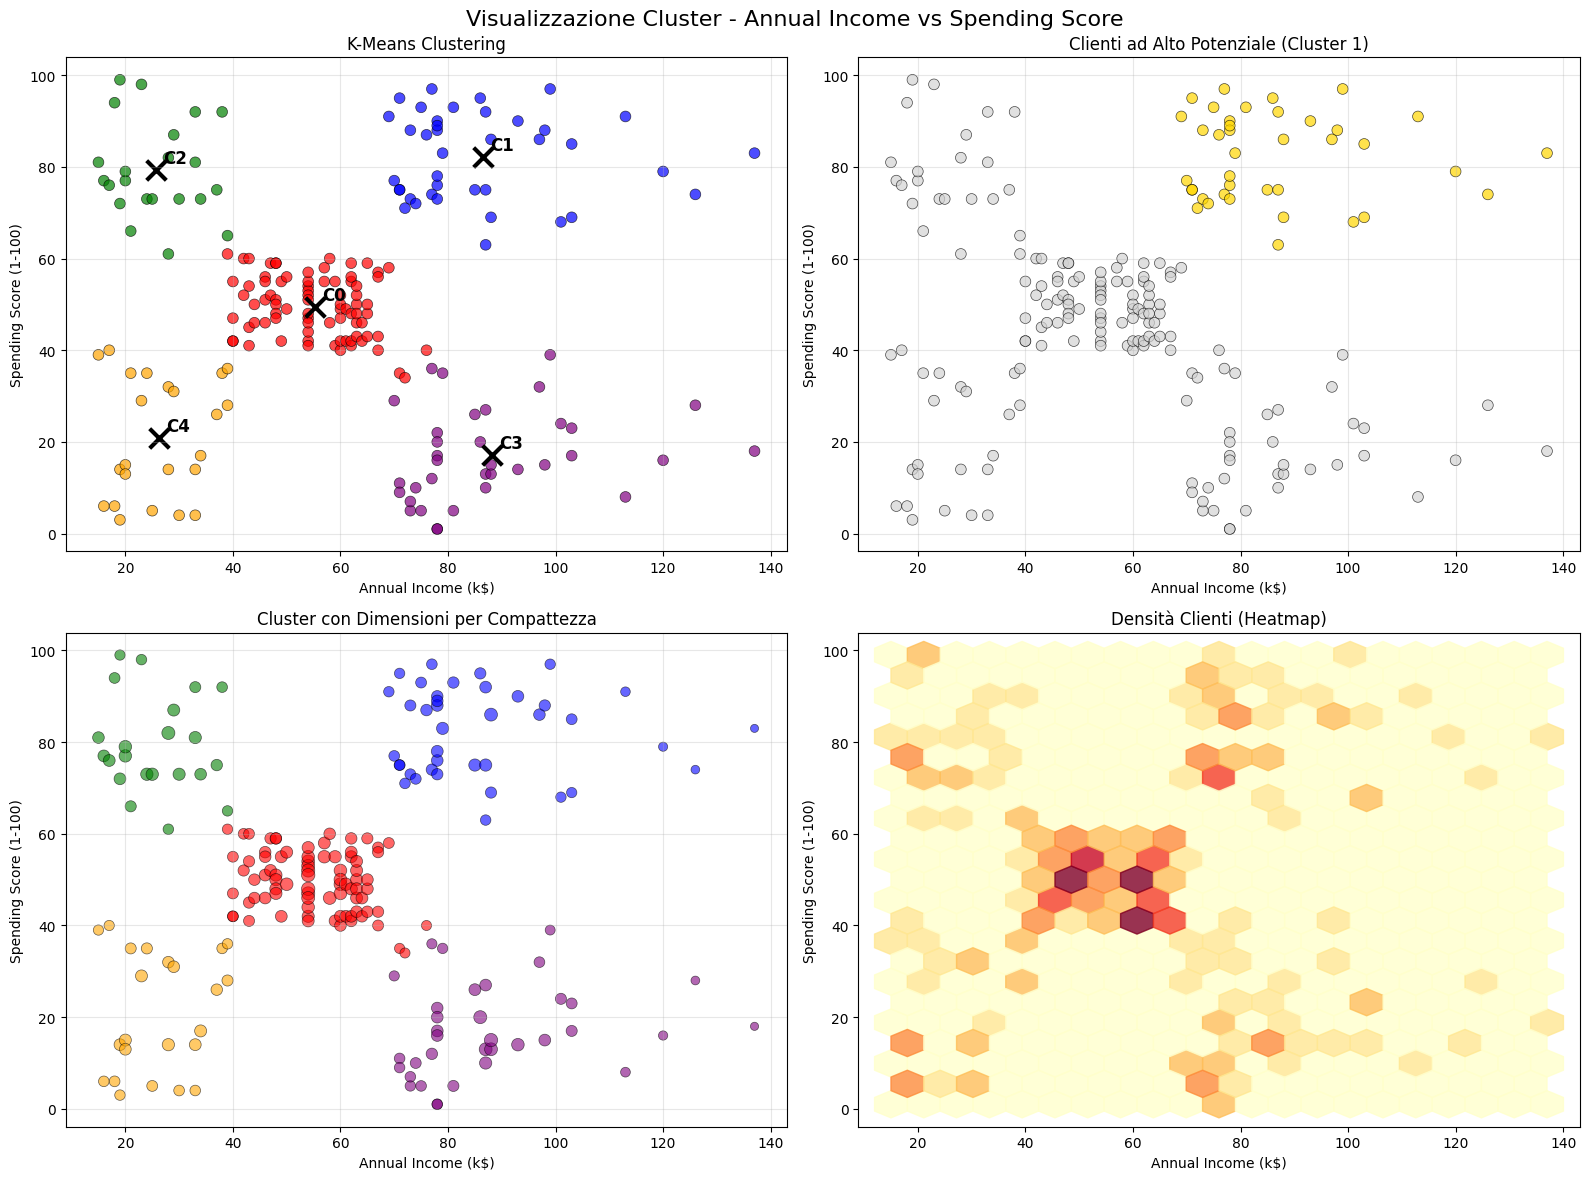

=== LEGENDA COLORI CLUSTER ===
 Cluster 0: RED (81 clienti)
 Cluster 1: BLUE (39 clienti)
 Cluster 2: GREEN (22 clienti)
 Cluster 3: PURPLE (35 clienti)
 Cluster 4: ORANGE (23 clienti)

 Cluster ad Alto Potenziale: 1 (BLUE)
 Centroidi: Croce nera


In [84]:
# Visualizzazione dei cluster in 2D con colori diversi per ogni gruppo
plt.figure(figsize=(15, 10))

# Crea una griglia di subplot per diverse visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Visualizzazione Cluster - Annual Income vs Spending Score', fontsize=16)

# 1. Scatter plot con cluster K-Means
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
scatter1 = axes[0,0].scatter(customer_features_engineered['annual_income'], 
                            customer_features_engineered['spending_score'],
                            c=[colors[label] for label in kmeans_labels], 
                            alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

# Aggiungi centroidi
for i, centroid in enumerate(centroids_original):
    axes[0,0].scatter(centroid[0], centroid[1], c='black', marker='x', s=200, linewidth=3)
    axes[0,0].annotate(f'C{i}', (centroid[0], centroid[1]), xytext=(5, 5), 
                      textcoords='offset points', fontsize=12, fontweight='bold')

axes[0,0].set_xlabel('Annual Income (k$)')
axes[0,0].set_ylabel('Spending Score (1-100)')
axes[0,0].set_title('K-Means Clustering')
axes[0,0].grid(True, alpha=0.3)

# 2. Evidenzia il cluster ad alto potenziale
scatter2 = axes[0,1].scatter(customer_features_engineered['annual_income'], 
                            customer_features_engineered['spending_score'],
                            c=['gold' if label == high_potential_cluster else 'lightgray' for label in kmeans_labels],
                            alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
axes[0,1].set_xlabel('Annual Income (k$)')
axes[0,1].set_ylabel('Spending Score (1-100)')
axes[0,1].set_title(f'Clienti ad Alto Potenziale (Cluster {high_potential_cluster})')
axes[0,1].grid(True, alpha=0.3)

# 3. Visualizzazione con dimensioni diverse per compattezza
# Dimensione punto inversamente proporzionale alla distanza dal centroide
sizes = []
for i, label in enumerate(kmeans_labels):
    cluster_id = label
    point_distance = cluster_distances[cluster_id]
    # Trova l'indice del punto nel cluster
    cluster_indices = np.where(kmeans_labels == cluster_id)[0]
    point_idx_in_cluster = np.where(cluster_indices == i)[0][0]
    size = 100 / (1 + point_distance[point_idx_in_cluster])  # Punti più vicini = più grandi
    sizes.append(size)

scatter3 = axes[1,0].scatter(customer_features_engineered['annual_income'], 
                            customer_features_engineered['spending_score'],
                            c=[colors[label] for label in kmeans_labels], 
                            s=sizes, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1,0].set_xlabel('Annual Income (k$)')
axes[1,0].set_ylabel('Spending Score (1-100)')
axes[1,0].set_title('Cluster con Dimensioni per Compattezza')
axes[1,0].grid(True, alpha=0.3)

# 4. Heatmap delle zone di densità
axes[1,1].hexbin(customer_features_engineered['annual_income'], 
                 customer_features_engineered['spending_score'], 
                 gridsize=20, cmap='YlOrRd', alpha=0.8)
axes[1,1].set_xlabel('Annual Income (k$)')
axes[1,1].set_ylabel('Spending Score (1-100)')
axes[1,1].set_title('Densità Clienti (Heatmap)')

plt.tight_layout()
plt.show()

# Legenda dei colori per i cluster
print("=== LEGENDA COLORI CLUSTER ===")
for i in range(best_k):
    cluster_size = sum(kmeans_labels == i)
    print(f" Cluster {i}: {colors[i].upper()} ({cluster_size} clienti)")
    
print(f"\n Cluster ad Alto Potenziale: {high_potential_cluster} ({colors[high_potential_cluster].upper()})")
print(" Centroidi: Croce nera")

### 7. Interpretazione dei Cluster

In [85]:
# Interpretazione dei cluster trovati
print("=== INTERPRETAZIONE DEI CLUSTER ===\n")

for cluster_id in range(best_k):
    cluster_data = customer_features_engineered[customer_features_engineered['kmeans_cluster'] == cluster_id]
    
    avg_income = cluster_data['annual_income'].mean()
    avg_spending = cluster_data['spending_score'].mean()
    count = len(cluster_data)
    
    print(f"CLUSTER {cluster_id}:")
    print(f"  • Numero clienti: {count}")
    print(f"  • Annual Income medio: {avg_income:.1f}k$")
    print(f"  • Spending Score medio: {avg_spending:.1f}")
    print(f"  • Compattezza (distanza media dal centroide): {cluster_compactness[cluster_id]['mean_distance']:.3f}")
    
    # Identificazione se è il cluster ad alto potenziale
    if cluster_id == high_potential_cluster:
        print(f"  CLUSTER AD ALTO POTENZIALE (alto reddito + alto spending score)")
    
    print()

print(f" Cluster identificato come ad alto potenziale: Cluster {high_potential_cluster}")
print(f"   (Annual Income: {centroids_original[high_potential_cluster][0]:.1f}k$, Spending Score: {centroids_original[high_potential_cluster][1]:.1f})")

=== INTERPRETAZIONE DEI CLUSTER ===

CLUSTER 0:
  • Numero clienti: 81
  • Annual Income medio: 55.3k$
  • Spending Score medio: 49.5
  • Compattezza (distanza media dal centroide): 0.387

CLUSTER 1:
  • Numero clienti: 39
  • Annual Income medio: 86.5k$
  • Spending Score medio: 82.1
  • Compattezza (distanza media dal centroide): 0.627
  CLUSTER AD ALTO POTENZIALE (alto reddito + alto spending score)

CLUSTER 2:
  • Numero clienti: 22
  • Annual Income medio: 25.7k$
  • Spending Score medio: 79.4
  • Compattezza (distanza media dal centroide): 0.447

CLUSTER 3:
  • Numero clienti: 35
  • Annual Income medio: 88.2k$
  • Spending Score medio: 17.1
  • Compattezza (distanza media dal centroide): 0.625

CLUSTER 4:
  • Numero clienti: 23
  • Annual Income medio: 26.3k$
  • Spending Score medio: 20.9
  • Compattezza (distanza media dal centroide): 0.549

 Cluster identificato come ad alto potenziale: Cluster 1
   (Annual Income: 86.5k$, Spending Score: 82.1)
